In [2]:
from gurobipy import *

In [3]:
import shapely
import math
import pyproj
import sys
import fiona
sys.path.append('../../../alg')

import matplotlib.pyplot as plt, pandas as pd, geopandas as gpd, numpy as np, osmnx as ox
import distance_buffer as db, border_generators as bg, marching_army as ma

from matplotlib import pyplot
from functools import partial
from shapely import geometry
from shapely.ops import transform
from descartes import PolygonPatch
from matplotlib.patches import Arc
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from scipy.stats import truncnorm
%matplotlib inline

In [4]:
poop = gurobipy.Model("poop")

In [5]:
#THE FOLLOWING CODE COMES FROM: http://www.gurobi.com/documentation/8.0/examples/multiobj_py.html#subsubsection:multiobj.py

#!/usr/bin/python

# Copyright 2018, Gurobi Optimization, LLC

# Want to cover three different sets but subject to a common budget of
# elements allowed to be used. However, the sets have different priorities to
# be covered; and we tackle this by using multi-objective optimization.

from __future__ import print_function
from gurobipy import *

try:
    # Sample data
    Groundset = range(20)
    Subsets   = range(4)
    Budget    = 12;
    Set = [ [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ],
            [ 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1 ],
            [ 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0 ],
            [ 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0 ] ]
    SetObjPriority = [  3,    2,    2,   1]
    SetObjWeight   = [1.0, 0.25, 1.25, 1.0]

    # Create initial model
    model = Model('multiobj')

    # Initialize decision variables for ground set:
    # x[e] == 1 if element e is chosen for the covering.
    Elem = model.addVars(Groundset, vtype=GRB.BINARY, name='El')

    # Constraint: limit total number of elements to be picked to be at most
    # Budget
    model.addConstr(Elem.sum() <= Budget, name='Budget')

    # Set global sense for ALL objectives
    model.ModelSense = GRB.MAXIMIZE

    # Limit how many solutions to collect
    model.setParam(GRB.Param.PoolSolutions, 100)

    # Set and configure i-th objective
    for i in Subsets:
        objn = sum(Elem[k]*Set[i][k] for k in range(len(Elem)))
        model.setObjectiveN(objn, i, SetObjPriority[i], SetObjWeight[i],
                            1.0 + i, 0.01, 'Set' + str(i))

    # Save problem
    model.write('multiobj.lp')

    # Optimize
    model.optimize()

    model.setParam(GRB.Param.OutputFlag, 0)

    # Status checking
    status = model.Status
    if status == GRB.Status.INF_OR_UNBD or \
       status == GRB.Status.INFEASIBLE  or \
       status == GRB.Status.UNBOUNDED:
        print('The model cannot be solved because it is infeasible or unbounded')
        sys.exit(1)

    if status != GRB.Status.OPTIMAL:
        print('Optimization was stopped with status ' + str(status))
        sys.exit(1)

    # Print best selected set
    print('Selected elements in best solution:')
    for e in Groundset:
        if Elem[e].X > 0.9:
            print(' El%d' % e, end='')
    print('')

    # Print number of solutions stored
    nSolutions = model.SolCount
    print('Number of solutions found: ' + str(nSolutions))

    # Print objective values of solutions
    if nSolutions > 10:
        nSolutions = 10
    print('Objective values for first ' + str(nSolutions) + ' solutions:')
    for i in Subsets:
        model.setParam(GRB.Param.ObjNumber, i)
        print('\tSet%d' % i, end='')
        for e in range(nSolutions):
            model.setParam(GRB.Param.SolutionNumber, e)
            print(' %6g' % model.ObjNVal, end='')
        print('')

except GurobiError as e:
    print('Error code ' + str(e.errno) + ": " + str(e))

except AttributeError as e:
    print('Encountered an attribute error: ' + str(e))

Changed value of parameter PoolSolutions to 100
   Prev: 10  Min: 1  Max: 2000000000  Default: 10
Optimize a model with 1 rows, 20 columns and 20 nonzeros
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 4 objectives (3 combined) ...
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve time: 0.01s
Presolved: 1 rows and 20 columns
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (Set0) ...
---------------------------------------------------------------------------

Found heuristic solu

# Now let's try to implement our model in gurobipy

In [6]:
def distance(a,b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return math.sqrt(dx*dx + dy*dy)

In [7]:
#Problem Data

#FILL IN LATER
demandSites = [[1,2],[3,4],[4.5,5.3],[6.4,1.0],[4.5,3.3],[6.6,4.9],[8.4,4.3]]
demandWt = [20,30,2,5,19,3,14,12,8,12,27]
potlFacilitySites = [[5,6],[10,4],[0,1],[3.5,3],[4.5,1],[6.3,9],[5.5,2.5],[9.3,10.3],[2.1,1.5],
                    [1.7,3.3],[1.7,1.4]]

# potl covering distance for each site is the same for
# us in this simple initial try
S = 5.0 
#number of facilities to place
P=4

In [8]:
numDemandSites = len(demandSites)
numPotlFacilitySites = len(potlFacilitySites)

In [9]:
m = Model('C-MCLP-v0.0')

In [10]:
# X : POTL FACILITY SITES
x = m.addVars(range(numPotlFacilitySites), vtype=GRB.BINARY, name="x")
e = m.addVars(range(numPotlFacilitySites), vtype=GRB.BINARY, name="e")
y = m.addVars(range(numDemandSites), vtype=GRB.CONTINUOUS, name="y")

#Add Variables
#x = {}
#y = {}
#e = {}

#for j in range(numPotlFacilitySites):
#    x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)
#    e[j] = m.addVar(vtype=GRB.BINARY, name="e%d" % j)
    
#for i in range(numDemandSites):
#    y[i] = m.addVar(vtype=GRB.CONTINUOUS, name="y%d" % i)

In [11]:
# N[i] is the covering set of i (all j that can cover i)
N = {}
for i in range(numDemandSites):
    N[i] = []
    for j in range(numPotlFacilitySites):
        if distance(demandSites[i], potlFacilitySites[j]) <= S:
            N[i].append(j)
            

In [12]:
N

{0: [2, 3, 4, 6, 8, 9, 10],
 1: [0, 2, 3, 4, 6, 8, 9, 10],
 2: [0, 3, 4, 5, 6, 8, 9, 10],
 3: [1, 3, 4, 6, 8, 10],
 4: [0, 3, 4, 6, 8, 9, 10],
 5: [0, 1, 3, 4, 5, 6],
 6: [0, 1, 6]}

In [13]:
numDemandSites

7

In [14]:
# Add Constraints

#TODO - not sure what this does/where it should go
m.update()

for i in range(numDemandSites):
    #c1
    m.addConstr(quicksum(x[j] + y[i] for j in N[i]) >= 1)
    #c3
    m.addConstr(quicksum(x[j] + e[j] for j in N[i]) >= 1)
    
#c2
#m.addConstr(quicksum(x[j] for j in range(numPotlFacilitySites) == P))
m.addConstr(x.sum() == P)

#c4
# x[j] is 0 or 1
#c5
# e[j] is 0 or 1

#c6
for i in range(numDemandSites):
    m.addConstr(y[i] >= 0)


In [15]:
# Set global sense for ALL objectives
m.ModelSense = GRB.MINIMIZE

# Set Objectives
    #expr: New alternative objective.
    #index: Index for new objective. If you use an index of 0, this routine will change the primary optimization objective.
    #priority: Priority for the alternative objective.
    #weight: Weight for the alternative objective.
    #abstol: Absolute tolerance for the alternative objective. 
    #reltol: Relative tolerance for the alternative objective. 
    #name: Name of the alternative objective. 

#o1- min amt of demand that is NOT covered
m.setObjectiveN(quicksum(y[i]*demandWt[i] for i in range(numDemandSites)),
                    1, 1, 0.5, 2.0, 0.01,"Objective 1")

#o2 - (while) min'g w/e you need to add to cover everything
m.setObjectiveN(quicksum(e[j] for j in range(numPotlFacilitySites)),
                    2, 2, 0.5, 3.0, 0.01, "Objective 2")


In [16]:
try:
    m.optimize()
    m.setParam(GRB.Param.OutputFlag, 0)

    # Status checking
    status = m.Status
    if status == GRB.Status.INF_OR_UNBD or \
        status == GRB.Status.INFEASIBLE  or \
        status == GRB.Status.UNBOUNDED:
        print('The model cannot be solved because it is infeasible or unbounded')
        sys.exit(1)

    if status != GRB.Status.OPTIMAL:
        print('Optimization was stopped with status ' + str(status))
        sys.exit(1)

    # Print best selected set
    print('Selected elements in best solution:')
    for j in range(numPotlFacilitySites):
        if x[j].X > 0.9:
            print(' x%d' % j, end='')
        print('')

    # Print number of solutions stored
    nSolutions = m.SolCount
    print('Number of solutions found: ' + str(nSolutions))

    # Print objective values of solutions
    if nSolutions > 10:
        nSolutions = 10
    print('Objective values for first ' + str(nSolutions) + ' solutions:')
    for i in range(2): #num of objectives
        m.setParam(GRB.Param.ObjNumber, i)
        print('\tObj%d' % i, end='')
        for e in range(nSolutions):
            m.setParam(GRB.Param.SolutionNumber, e)
            print(' %6g' % m.ObjNVal, end='')
        print('')

except GurobiError as e:
    print('Error code ' + str(e.errno) + ": " + str(e))

except AttributeError as e:
    print('Encountered an attribute error: ' + str(e))

Optimize a model with 22 rows, 29 columns and 160 nonzeros
Variable types: 7 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 3 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 12 rows and 0 columns
Presolve time: 0.00s
Presolved: 10 rows and 29 columns
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (Objective 2) ...
---------------------------------------------------------------------------

Found heuristic solution: objective 0.5000000
Presolve removed 10 rows and 29 col

In [17]:
#N {demand_site_i: [facility_site_j that cover demand_site_i,...],...}
N

{0: [2, 3, 4, 6, 8, 9, 10],
 1: [0, 2, 3, 4, 6, 8, 9, 10],
 2: [0, 3, 4, 5, 6, 8, 9, 10],
 3: [1, 3, 4, 6, 8, 10],
 4: [0, 3, 4, 6, 8, 9, 10],
 5: [0, 1, 3, 4, 5, 6],
 6: [0, 1, 6]}

In [18]:
# so thhis checks out because3 we successfully picked out x[2] 
# (remember: x[j]==1 when we DO place site, 0 if not; e[j] is opp.)

# Now let's try to use Walnut Creek data with this model

- WC - walnut creek
- CC - contra costa county
- CA - california
- cXXXX where XXXX is a year - census of year XXXX
- bg - block group
- RoI - region of interest

In [19]:
g

NameError: name 'g' is not defined

##### METHODS

In [31]:
#transform to meters so we can do math on the RoI
proj2 = partial(pyproj.transform, pyproj.Proj(init='epsg:4269'),pyproj.Proj(init='epsg:3857'))


In [32]:
# filter collection based on a places commonly known name
# filter_value : String - the value by which you wish to filter property prop by 
# prop: String - the property in the "properties" that you want to filter fcollection by
# fcollection : a shapely collection of data 
# RETURNS: list - of matching entries found in fcollection
def filter_by_property(filter_value, prop, fcollection):
    matches = []
    for i in range(0, len(fcollection)):
        if fcollection[i]['properties'][prop] == filter_value:
            matches.append(fcollection[i])
  
    return matches


In [33]:
def remove_duplicate_blocks(collec):
    temp_data = []
    dups = []
    listofids = []
    for i in range(0, len(collec)):
        cur = collec[i]
        tid = str(cur['properties']['BLOCKID10'])
        if tid not in listofids:
            listofids.append(tid)
            temp_data.append(cur)
        else:
            dups.append(cur)
            
    # MAKE SURE NONE OF THE BLOCKS YOU ELIMINATED HAVE A DIFFERENT POP
    for i in range(0, len(dups)):
        thedup = str(dups[i]['properties']['BLOCKID10'])
        for j in range(0, len(temp_data)):
            if thedup == str(temp_data[j]['properties']['BLOCKID10']):
                p1 = dups[i]['properties']['POP10']
                p2 = temp_data[j]['properties']['POP10']
                if not p1==p2:
                    print(p1)
                    print(p2)
                    
    return temp_data

In [34]:
# generate N random coords within the SQUARE BOUNDS bds [minx,miny,maxx,maxy]
# RETURNS: xs - x coordinate list of rand coords
#          ys - y coord list of rand coords 
def gen_n_random_coords(bds, n):
    xs = []
    ys = []
    for i in range(0,n):
        xs.append(ma.gen_rand_pt(bds[0], bds[2]))
        ys.append(ma.gen_rand_pt(bds[1],bds[3]))
    return xs, ys

In [35]:
#generate points for the whole RoI
def filter_random_pts_by_RoI(x_rands, y_rands, RoI_bg_geoms, pop_data_schema):

    # turn x list and y list into coords
    random_pts_all = gpd.GeoDataFrame(data={'x':x_rands, 'y':y_rands})
    random_pts_all['geometry'] = random_pts_all.apply(lambda row: Point((row['x'], row['y'])), axis=1)
    # create index for all random pts
    all_pts_sindex = random_pts_all.sindex

    #now find ones that intercept the region by BG

    pts_per_bg = []
    pops_per_bg= []


    for i in range(0,len(pop_data_schema)):
        tbg_pop = pop_data_schema[i]['properties']['POP10']
        pops_per_bg.append(tbg_pop)
        all_precise_matches = []
        if tbg_pop > 0: # only check for point intersections if the population >0
            poly = RoI_bg_geoms[i]
            polybds = poly.bounds 
        
            all_possible_matches_index = list(all_pts_sindex.intersection(polybds))
            all_possible_matches = random_pts_all.iloc[all_possible_matches_index]
            all_precise_matches = all_possible_matches[all_possible_matches.intersects(poly)]
        
            while len(all_precise_matches)==0:
            #gen new random points focused on the BG at hand
                tx, ty = gen_n_random_coords(polybds, 10)
                trandom_pts = gpd.GeoDataFrame(data={'x':tx, 'y':ty})
                trandom_pts['geometry'] = trandom_pts.apply(lambda row: Point((row['x'], row['y'])), axis=1)
                trandom_pts_sindex = trandom_pts.sindex
            
                tpossible_matches_index = list(trandom_pts_sindex.intersection(polybds))
                tpossible_matches = trandom_pts.iloc[tpossible_matches_index]
                all_precise_matches = tpossible_matches[tpossible_matches.intersects(poly)]
            
        
            # make sure there's not more points than people in the bg
            if len(all_precise_matches) > tbg_pop:
                all_precise_matches = all_precise_matches[0:tbg_pop]
        
        pts_per_bg.append(all_precise_matches)
        
    return pts_per_bg#, pops_per_bg

In [36]:
def plot_geoms(mpoly, scatterlist=[], scattercolorlist=['r'], scatter=False, fc="#cccccc", ec="#000000", alpha=0.5, zorder=1, savefig=False, figname="xxx.png", axisonoff="off"):
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    for poly in mpoly:
        patch = PolygonPatch(poly, fc=fc, ec=ec, alpha=alpha, zorder=zorder)
        ax.add_patch(patch)
    if scatter == True:    
        for j in range(len(scatterlist)):
            ptcollec = scatterlist[j]
            for i in range(len(ptcollec)):
                if len(ptcollec[i]) > 0:
                    ax.scatter(x=ptcollec[i]['x'], y=ptcollec[i]['y'], s=1, c=scattercolorlist[j], linewidth=0, zorder=2)
    
    west,south,east,north=mpoly.bounds
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    ax.axis(axisonoff)
    if savefig:
        plt.savefig(figname,  dpi=192 * 10)
    return fig,ax

In [37]:
def assign_pops_to_pts(pts_per_bg, pops_per_bg):
    pop_partitions = []
    
    for i in range(0, len(pts_per_bg)):
        bgpop = pops_per_bg[i]['properties']['POP10']
        bgpts = pts_per_bg[i]
        numpts = len(bgpts)
        pop_remains = bgpop
        pt_remains = numpts
        #print "NEW IIIII"
        
        partition = []
        partition_not_found = True
        # only partition pts if nonzero pop
        if bgpop == 0:
            #print "0 pop"
            pop_partitions.append(partition)
            partition_not_found = False
        elif bgpop == numpts: # simple partition each pt gets 1
            #print "each part gets 1"
            partition = [1]*numpts
            pop_partitions.append(partition)
            partition_not_found = False
        elif numpts > bgpop: # too many pts for the total pop, shave off some pts and assign 1's
            #print "too many pops for the pt"
            pts_per_bg[i] = pts_per_bg[i][0:bgpop]
            partition = [1]*bgpop
            pop_partitions.append(partition)
            partition_not_found = False
            
        # non simple partition case; now find the partition
        while partition_not_found: # loop until we find the partition
            #print "IN WHILE"
            #print i
            #print "bgpop "+str(bgpop)
            #print "numpts "+str(numpts)
            #print "pop_remains "+str(pop_remains)
            #print "pt_remains "+str(pt_remains)
                
            if pop_remains == pt_remains:
                #print "pop remain is pt remain"
                # if the # pts left ever =='s the # pop left, 
                # just assign 1's to the rest of the pts
                partition.extend(([1]*pop_remains))
                pop_partitions.append(partition)
                partition_not_found = False
                continue
            elif pop_remains < pt_remains: # not enough pop left to cover the remaining pts; start over
                pop_remains = bgpop
                pt_remains = numpts
                partition = []
                
            if pt_remains == 1:
                #print "last one,"
                partition.append(pop_remains)
                pop_partitions.append(partition)
                partition_not_found = False
                continue
            
                    
            randnum = np.random.randint(1,pop_remains)
            partition.append(randnum)
            # decrease remaining pts and pops accordingly
            pop_remains = pop_remains-randnum
            pt_remains -= 1
    
    #print pop_partitions
    return pop_partitions

In [38]:
#make sure all the sums and pops are equal
def test_pop_pt_agreement(pops_bg, popassigs, pts_bg):
    for i in range(0, len(popassigs)):
        t = popassigs[i]
        pts = pts_bg[i]
        #print t
        tsum = 0
        ptcnt = 0
        for j in range(0, len(t)):
            tsum +=t[j]
        for j in range(0, len(pts)):
            ptcnt += 1
        if not tsum == pops_bg[i]['properties']['POP10']:
            print("POP DISAGREEMENT")
            print("I "+str(i))
            print(tsum)
            print(pops_bg[i])
        if not ptcnt == len(t):
            print("PTCNT DISAGREEMENT")
            print(ptcnt)
            print(len(t))

### Processing Code

In [40]:
bg_data_CA_c2010 = fiona.open("../../../data/CA_WalnutCreek/CA_pop_bg/tabblock2010_06_pophu.shp")

# filter to geometry of only CC county 
#(we need to get + match the place code for WC)
# before we can filter it down to only WC

COUNTYCODE = '013'

bg_data_CC_c2010 = []
for i in range(0, len(bg_data_CA_c2010)):
    if bg_data_CA_c2010[i]['properties']['COUNTYFP10'] == COUNTYCODE:
        bg_data_CC_c2010.append(bg_data_CA_c2010[i])


In [41]:
# read in CA places file to get the PLACECODE for WC
places_data_CA_c2010 = fiona.open("../../../data/CA_WalnutCreek/CA_places/tl_2010_06_place10.shp")

PLACENAME = "Walnut Creek"
# get an array of geoms  name of the place
bg_data_WC_c2010 = filter_by_property(PLACENAME,'NAME10',places_data_CA_c2010)


In [42]:
# get the shapely geometry of the BGs for WC
bg_geoms_WC_c2010 = geometry.shape(bg_data_WC_c2010[0]['geometry'])
# turn it into a multipolygon for easier processing
bg_geoms_WC_c2010 = MultiPolygon([bg_geoms_WC_c2010])

In [43]:
# read in the CC faces file to get BG info and their codes

# read in FACES file 
faces_data_CC_c2010 = fiona.open("../../../data/CA_WalnutCreek/CTY_faces/tl_2010_06013_faces.shp")



In [44]:
# match the PLACECODE to the data in the FACES file to get WC's BG data
PLACECODE = bg_data_WC_c2010[0]['properties']['PLACEFP10']


In [45]:
faces_data_WC_c2010 = filter_by_property(PLACECODE,'PLACEFP10',faces_data_CC_c2010)


In [46]:
# now we have all the BG info we need to get the populations in WC

bg_pops_WC_c2010 = []

for i in range(0, len(faces_data_WC_c2010)):
    cur = faces_data_WC_c2010[i]
    matchstr = str(cur['properties']['STATEFP10'])+ str(cur['properties']['COUNTYFP10'])+ str(cur['properties']['TRACTCE10'])+ str(cur['properties']['BLOCKCE10'])
    bg_pops_WC_c2010.append(filter_by_property(matchstr, 'BLOCKID10', bg_data_CC_c2010)[0])



In [47]:
# remove BG's with duplicate BLOCKIDs
temp_bg_pops_WC_c2010 = remove_duplicate_blocks(bg_pops_WC_c2010)

In [48]:
bg_pops_WC_c2010 = temp_bg_pops_WC_c2010

In [49]:
# turn coords into actual shapley shapes
bg_pop_geoms_WC_c2010 = []
for i in range(len(temp_bg_pops_WC_c2010)):
    bg_pop_geoms_WC_c2010.append(geometry.shape(temp_bg_pops_WC_c2010[i]['geometry']))


In [50]:
bg_pop_geoms_WC_c2010 = MultiPolygon(bg_pop_geoms_WC_c2010)

In [51]:
for i in range(0, len(bg_pops_WC_c2010)):
    if type(bg_pops_WC_c2010[i]) != dict:
        print(i)

###### Got all the data we need and joined it so now we can move on to generating our random data

In [52]:
#we have to transform everything to meters so we can operate on the coords
tbg_pop_geoms_WC_c2010 = []
for i in range(len(bg_pop_geoms_WC_c2010)):
    tbg_pop_geoms_WC_c2010.append(transform(proj2, bg_pop_geoms_WC_c2010[i]))
    
tbg_pop_geoms_WC_c2010 = MultiPolygon(tbg_pop_geoms_WC_c2010)
    

In [53]:
west,south,east,north = tbg_pop_geoms_WC_c2010.bounds
xrands, yrands = gen_n_random_coords([west,south,east,north], 5000)
rnd_demand_pts_WC = filter_random_pts_by_RoI(xrands,yrands,tbg_pop_geoms_WC_c2010, bg_pops_WC_c2010)



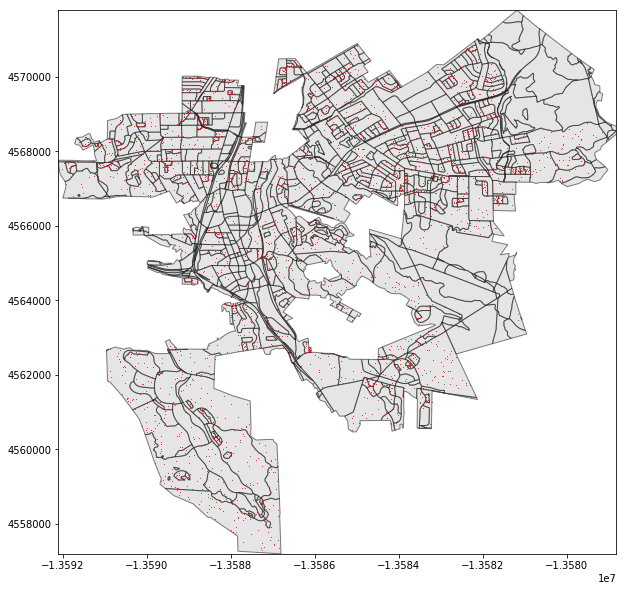

In [54]:
fig1,ax1 = plot_geoms(tbg_pop_geoms_WC_c2010, scatterlist=[rnd_demand_pts_WC],
                     scatter=True, axisonoff='on')



### This is a SUPER NAIVE (read: quick) integer partition w/ the goal of the splitting up the population in the BGs amongst the rand. generated pts in them. 

In [55]:
pop_demand_pt_assigs = assign_pops_to_pts(rnd_demand_pts_WC, bg_pops_WC_c2010)


In [56]:
type(rnd_demand_pts_WC[0])

geopandas.geodataframe.GeoDataFrame

In [57]:
test_pop_pt_agreement(bg_pops_WC_c2010, pop_demand_pt_assigs, rnd_demand_pts_WC)

#### Now we have the demand points and have assigned them their populations based on the 2010 census data from their corresponding BG.
### Now let's generate the grid of candidate pts
- REMEMBER: it is a TRIANGLE grid not a square grid so we need to shift every other row (x) or column (y) to abide by this
- $optdist = r* \sqrt{3}$
- shift for every other: $shift = \frac{r}{2} * \sqrt{3}$


In [58]:
R = 100.0
OPTDIST_CIRCLECENTER = R * math.sqrt(3.0)
SHIFT = OPTDIST_CIRCLECENTER/2.0

In [33]:
gridptstry1 = gpd.read_file('../MarchingArmyBased/gridpts.shp')

In [34]:
len(gridptstry1)

2713

In [60]:
bounds = [west,south,east,north]
diags = [distance([west,north],[east,south]), distance([west,south],[east,north])]
maxdiag = max(diags)

interval = int(math.ceil(maxdiag/OPTDIST_CIRCLECENTER))

stopx = bounds[0]+(interval*OPTDIST_CIRCLECENTER)
stopy = bounds[1]+(interval*OPTDIST_CIRCLECENTER)

# create the equally spaced coord points for the "grid" cand pts
xs = np.linspace(west,stopx,interval)
ys = np.linspace(south,stopy,interval)

# create the grid
x_grid,y_grid = np.meshgrid(xs, ys)



In [65]:
%%time
possible_matches_index = list(grid_index.intersection(bounds))
possible_matches = gridgdf.iloc[possible_matches_index]

CPU times: user 9.79 ms, sys: 6.67 ms, total: 16.5 ms
Wall time: 14.8 ms


In [59]:
def generate_grid(rad, bds):
    # get the largest diagonal dist and this is what we will make 
    #our regtangle of points on the grid based on (so when we shift/rotate the whole 
    #shape will be covered still)
    [west, south, east, north] = bds
    bounds = [west,south,east,north]
    diags = [db.eucdist(west,north,east,south)[0], db.eucdist(west,south,east,north)[0]]
    maxdiag = max(diags)
    
    #generate the "two" grids
    r = rad
    x_shift = (r/2.0)*math.sqrt(3)
    y_shift = (3.0/2.0)*r

    x_ints = int(math.ceil(maxdiag/x_shift))
    y_ints = int(math.ceil(maxdiag/y_shift))

    stopx = bounds[0]+(x_ints*x_shift)
    stopy = bounds[1]+(y_ints*y_shift)

    # create the equally spaced coord points for the "grid" cand pts
    xs_all = np.linspace(west,stopx,x_ints+1)
    ys_all = np.linspace(south,stopy,y_ints+1)
    print(xs_all)
    print(ys_all)
    
    # now take odds with odds and evens with evens ("2" grids)
    xs_odd = []
    xs_even = []
    ys_odd = []
    ys_even = []

    for i in range(0,len(xs_all)):
        if i%2 == 0:
            xs_even.append(xs_all[i])
        else:
            xs_odd.append(xs_all[i])
    for i in range(0,len(ys_all)):
        if i%2 == 0:
            ys_even.append(ys_all[i])
        else:
            ys_odd.append(ys_all[i])

    xs_odd = np.array(xs_odd)
    xs_even = np.array(xs_even)
    ys_odd = np.array(ys_odd)
    ys_even = np.array(ys_even)

    x_grid1, y_grid1 = np.meshgrid(xs_odd, ys_odd)
    x_grid2, y_grid2 = np.meshgrid(xs_even, ys_even)
    
    # create the data dicts that will create the geodataframe
    data1={'x':x_grid1.flatten(), 'y':y_grid1.flatten()}
    data2={'x':x_grid2.flatten(), 'y':y_grid2.flatten()}
    
    data_all = data1.copy()   # start with x's keys and values
    data_all.update(data2)

    grid1gdf = gpd.GeoDataFrame(data={'x':x_grid1.flatten(), 'y':y_grid1.flatten()})
    grid2gdf = gpd.GeoDataFrame(data={'x':x_grid2.flatten(), 'y':y_grid2.flatten()})
    
    gridgdf = gpd.GeoDataFrame( pd.concat( [grid1gdf,grid2gdf], ignore_index=True) )
    gridgdf['geometry'] = gridgdf.apply(lambda row: Point((row['x'], row['y'])), axis=1)

    return gridgdf

### the regular rtree procedure i've used before is taking WAY too long... I have no idea why this is so slow when it was so fast before? (its still fast in the other program. investigate later)

In [64]:
#%%time
#precise_matches = possible_matches[possible_matches.intersects(tbg_pop_geoms_WC_c2010)]


In [62]:
# lets try a more sophisticated procedure:
# get the possible matches for the BBOX of the ENTIRE RoI
# loop through the multipolygons & get their BBOX's, intersect w/ grid index
#       precisely match those potl matches + append precise matches to array
# repeat w/ next multipolygon piece

#-------- INDEX CREATION --------

# create the GDF for the rtree intersection
gridgdf = gpd.GeoDataFrame(data={'x':x_grid.flatten(), 'y':y_grid.flatten()})

# transform the grid pts for indexing
gridgdf['geometry'] = gridgdf.apply(lambda row: Point((row['x'], row['y'])), axis=1)
#create the grid index
grid_index = gridgdf.sindex

possible_matches_index = list(grid_index.intersection(bounds))
possible_matches = gridgdf.iloc[possible_matches_index]

precise_matches = []

for poly in tbg_pop_geoms_WC_c2010:
    pbds = poly.bounds
    
    pall_possible_matches_index = list(grid_index.intersection(pbds))
    pall_possible_matches = gridgdf.iloc
    




In [61]:
trianggridgdf = generate_grid(100.0, tbg_pop_geoms_WC_c2010.bounds)

[-13592111.0503731  -13592024.44783272 -13591937.84529234
 -13591851.24275197 -13591764.64021159 -13591678.03767121
 -13591591.43513083 -13591504.83259045 -13591418.23005007
 -13591331.6275097  -13591245.02496932 -13591158.42242894
 -13591071.81988856 -13590985.21734818 -13590898.6148078
 -13590812.01226743 -13590725.40972705 -13590638.80718667
 -13590552.20464629 -13590465.60210591 -13590378.99956553
 -13590292.39702515 -13590205.79448478 -13590119.1919444
 -13590032.58940402 -13589945.98686364 -13589859.38432326
 -13589772.78178288 -13589686.1792425  -13589599.57670213
 -13589512.97416175 -13589426.37162137 -13589339.76908099
 -13589253.16654061 -13589166.56400023 -13589079.96145986
 -13588993.35891948 -13588906.7563791  -13588820.15383872
 -13588733.55129834 -13588646.94875796 -13588560.34621759
 -13588473.74367721 -13588387.14113683 -13588300.53859645
 -13588213.93605607 -13588127.33351569 -13588040.73097531
 -13587954.12843494 -13587867.52589456 -13587780.92335418
 -13587694.32081

In [62]:
len(trianggridgdf)

15229

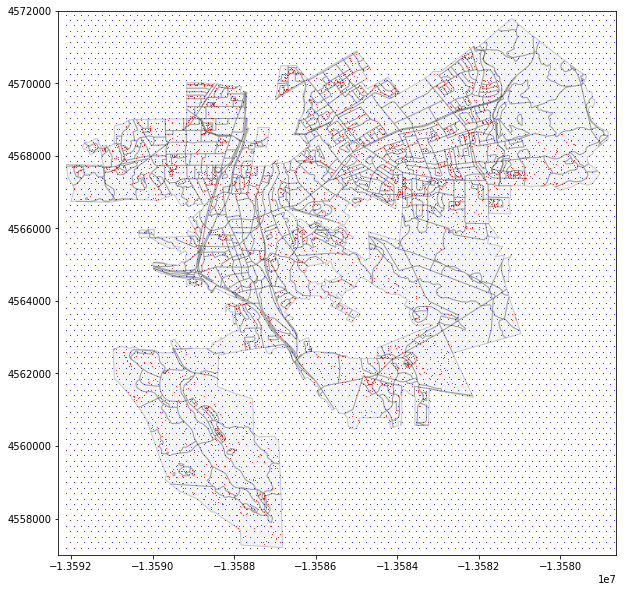

In [63]:
# plot the cut-up city
fig2, ax2 = plt.subplots(figsize=(10,10))
for polygon in tbg_pop_geoms_WC_c2010:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=0)
    ax2.add_patch(patch)

#ax2.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=2)
ax2.scatter(x=trianggridgdf['x'], y=trianggridgdf['y'], s=1, c='b', linewidth=0, zorder=3)
#ax2.scatter(x=possible_matches['x'], y=possible_matches['y'], s=1, c='r', linewidth=0, zorder=2)

for i in range(0, len(rnd_demand_pts_WC)):
    bgpts = rnd_demand_pts_WC[i]
    if len(bgpts) > 0:
        ax2.scatter(x=bgpts['x'], y=bgpts['y'], s=1, c='r', linewidth=0, zorder=4)

ax2.set_xlim(west-200, east+200)
ax2.set_ylim(south-200, north+200)
ax2.axis('on')
plt.savefig("grid_allpts_w_randpts.png",  dpi=192 * 10)
plt.show()

### lets grab a chunk thats not as big as the whole entire RoI to experiment on


In [392]:
#lets grab a chunk thats not as big as the whole entire RoI to experiment on
gridpts_all_index = gridpts_all.sindex
r =100.0
chunkbds = [-13590000, 4560000,-13588000,4562000]
chunkbds_plus = [chunkbds[0]-r-10, chunkbds[1]-r-10, chunkbds[2]+r+10, chunkbds[3]+r+10]
facilitypt_matches_index = list(gridpts_all_index.intersection(chunkbds_plus))
facilitypt_matches = gridpts_all.iloc[facilitypt_matches_index]


In [393]:
len(facilitypt_matches_index)

188

In [394]:
poop = gpd

In [395]:
type(rnd_demand_pts_WC[0])

geopandas.geodataframe.GeoDataFrame

In [396]:
dmd_matches = []
for i in range(len(rnd_demand_pts_WC)):
    if len(rnd_demand_pts_WC[i])>0:
        dmdpts_index = rnd_demand_pts_WC[i].sindex
        demandpt_matches_index = list(dmdpts_index.intersection(chunkbds))
        demand_matches = rnd_demand_pts_WC[i].iloc[demandpt_matches_index]
        if len(demand_matches)>0:
            dmd_matches.append(demand_matches)
    
    
    
    


In [397]:
len(dmd_matches)

25

In [398]:

facility_matches_coords = []
for key,item in facilitypt_matches['geometry'].iteritems():
    facility_matches_coords.append(item.coords[0])

In [399]:
dmd_matches_coords = []
for l in dmd_matches:
    if len(l)>0:
        for key,item in l['geometry'].iteritems():
            dmd_matches_coords.append(item.coords[0])

In [400]:
random_wts = []
for i in range(len(dmd_matches_coords)):
    random_wts.append(np.random.randint(1,30))

In [401]:
len(random_wts)

142

In [402]:
len(facility_matches_coords)

188

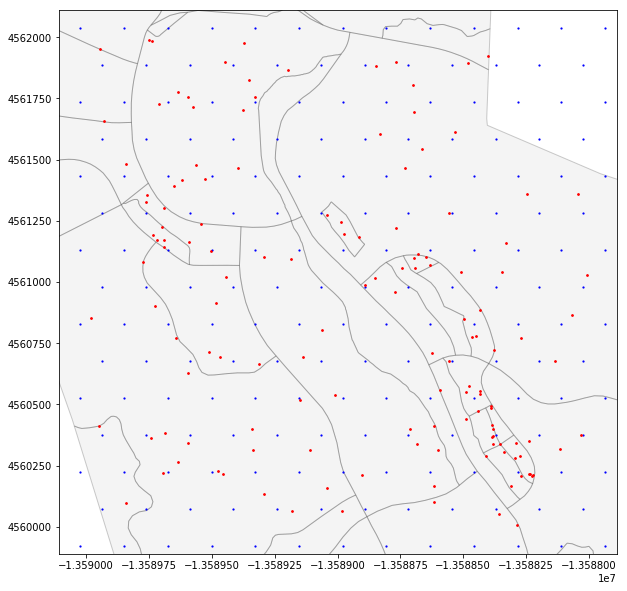

In [403]:
# plot the cut-up city
fig3, ax3 = plt.subplots(figsize=(10,10))
for polygon in tbg_pop_geoms_WC_c2010:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=0)
    ax3.add_patch(patch)
tempx,tempy = zip(*facility_matches_coords)

ax3.scatter(x=tempx,y=tempy, s=5, c='b', linewidth=0, zorder=3)

#ax3.plot([facility_matches_coords[0][0]],[facility_matches_coords[0][1]],marker='o', markersize=4, color="black")
#db.plot_radii(ax3, [facility_matches_coords[0][0],facility_matches_coords[0][1]], 100.0, alpha=0.5, color="pink")

for i in range(0, len(dmd_matches)):
    bgpts = dmd_matches[i]
    if len(bgpts) > 0:
        ax3.scatter(x=bgpts['x'], y=bgpts['y'], s=3, c='r', zorder=4)

ax3.scatter(x=gridpts['x'], y=gridpts['y'], s=1, c='b', linewidth=0, zorder=5)

#ax3.plot(dmd_matches_coords[58][0], dmd_matches_coords[58][1], '*')

ax3.set_xlim(chunkbds_plus[0], chunkbds_plus[2])
ax3.set_ylim(chunkbds_plus[1], chunkbds_plus[3])
ax3.axis('on')
#plt.savefig("grid_candpts_w_randpts.png",  dpi=192 * 10)
plt.show()

In [404]:
len(dmd_matches_coords)

142

## Read in the gridpts

In [4]:
gridpts = gpd.read_file('../MarchingArmyBased/gridpts_triangular.shp')


In [5]:
gridpts_all = gpd.read_file('../MarchingArmyBased/gridpts_triangular_ALL.shp')

In [6]:
len(gridpts_all)

15048

In [378]:
dmd_matches_coords = []
random_wts = []

for l in rnd_demand_pts_WC:
    if len(l)>0:
        for key,item in l['geometry'].iteritems():
            dmd_matches_coords.append(item.coords[0])
            
for l in pop_demand_pt_assigs:
    ll = len(l)
    if ll>0:
        for i in range(0,ll):
            random_wts.append(l[i])

In [379]:
facility_matches_coords = []
for key,item in gridpts['geometry'].iteritems():
    facility_matches_coords.append(item.coords[0])

In [380]:
len(random_wts)


2804

In [381]:
tmp_dmd_matches_coords = []
for i in range(0, len(dmd_matches_coords)):
    if i!=58:
        tmp_dmd_matches_coords.append(dmd_matches_coords[i])
dmd_matches_coords = tmp_dmd_matches_coords

In [382]:
random_wts = random_wts[0:141]

In [383]:
len(facility_matches_coords)

3131

###### --- whole region

In [64]:
def gdf_to_list(gdf):
    tmp = []
    for key,item in gdf['geometry'].iteritems():
        tmp.append(item.coords[0])
        
    return tmp

In [65]:
tmp_demandpts = []
for l in rnd_demand_pts_WC:
    if len(l)>0:
        for key,item in l['geometry'].iteritems():
            tmp_demandpts.append(item.coords[0])
            

In [66]:
tmp_facilitypts = gdf_to_list(trianggridgdf)

In [67]:
tmp_wts = []
for l in pop_demand_pt_assigs:
    ll = len(l)
    if ll>0:
        for i in range(0,ll):
            tmp_wts.append(l[i])

# GUROBI MODEL

In [69]:
#Problem Data

#FILL IN LATER
demandSites = tmp_demandpts#[[1,2],[3,4],[4.5,5.3],[6.4,1.0],[4.5,3.3],[6.6,4.9],[8.4,4.3]]
demandWt = tmp_wts #[20,30,2,5,19,3,14,12,8,12,27]
potlFacilitySites = tmp_facilitypts #[[5,6],[10,4],[0,1],[3.5,3],[4.5,1],[6.3,9],[5.5,2.5],[9.3,10.3],[2.1,1.5],
                    #[1.7,3.3],[1.7,1.4]]

# potl covering distance for each site is the same for
# us in this simple initial try
S = 100.0


numDemandSites = len(demandSites)
numPotlFacilitySites = len(potlFacilitySites)

m = Model('C-MCLP-v0.0')

# N[i] is the covering set of i (all j that can cover i)
N = {}
for i in range(numDemandSites):
    N[i] = []
    for j in range(numPotlFacilitySites):
        if distance(demandSites[i], potlFacilitySites[j]) <= S:
            N[i].append(j)

#N[98]=[]


In [81]:
N[200]

[3899, 11572]

In [88]:
type(tmp_wts)

list

In [92]:
tmp_demandpts[200]

(-13588113.699777437, 4567611.595416644)

In [70]:
#number of facilities to place
P=300

In [71]:
# X : POTL FACILITY SITES
x = m.addVars(range(numPotlFacilitySites), vtype=GRB.BINARY, name="x")
e = m.addVars(range(numPotlFacilitySites), vtype=GRB.BINARY, name="e")
y = m.addVars(range(numDemandSites), vtype=GRB.CONTINUOUS, name="y")


In [72]:
            
# Add Constraints

#TODO - not sure what this does/where it should go
m.update()

for i in range(numDemandSites):
    #c1
    m.addConstr(quicksum(x[j] + y[i] for j in N[i]) >= 1)
    #c3
    m.addConstr(quicksum(x[j] + e[j] for j in N[i]) >= 1)
    
#c2
#m.addConstr(quicksum(x[j] for j in range(numPotlFacilitySites) == P))
m.addConstr(x.sum() == P)

#c4
# x[j] is 0 or 1
#c5
# e[j] is 0 or 1

#c6
for i in range(numDemandSites):
    m.addConstr(y[i] >= 0)



In [73]:
# Set global sense for ALL objectives
m.ModelSense = GRB.MINIMIZE

# Set Objectives
    #expr: New alternative objective.
    #index: Index for new objective. If you use an index of 0, this routine will change the primary optimization objective.
    #priority: Priority for the alternative objective.
    #weight: Weight for the alternative objective.
    #abstol: Absolute tolerance for the alternative objective. 
    #reltol: Relative tolerance for the alternative objective. 
    #name: Name of the alternative objective. 

index = [0,1]
priority = [0,0]
weight = [1.,1.]
abstol = [0.,0.]
reltol = [0.,0.]
    
#o1- min amt of demand that is NOT covered
m.setObjectiveN(quicksum(y[i]*demandWt[i] for i in range(numDemandSites)),
                    index[0], priority[0], weight[0], reltol=reltol[0])#, abstol[0], reltol[0])

#o2 - (while) min'g w/e you need to add to cover everything
m.setObjectiveN(quicksum(e[j] for j in range(numPotlFacilitySites)),
                    index[1], priority[1], weight[1], reltol=reltol[1])#, abstol[1], reltol[1])


In [74]:
#%tb
siteschosen = []
try:
    m.optimize()
    m.setParam(GRB.Param.OutputFlag, 0)

    # Status checking
    status = m.Status
    if status == GRB.Status.INF_OR_UNBD:
        print("Inf or unbd")
    elif status == GRB.Status.INFEASIBLE:
        print("infeasible")
    elif status == GRB.Status.UNBOUNDED:
        print("unbounded")
    elif status == GRB.Status.OPTIMAL:
        print("optimal")
    else:
        print(str(status))
        
    if status == GRB.Status.INF_OR_UNBD or \
        status == GRB.Status.INFEASIBLE  or \
        status == GRB.Status.UNBOUNDED:
        print('The model cannot be solved because it is infeasible or unbounded')
        sys.exit(1)

    if status != GRB.Status.OPTIMAL:
        print('Optimization was stopped with status ' + str(status))
        sys.exit(1)

    # Print best selected set
    print('Selected elements in best solution:')
    for j in range(numPotlFacilitySites):
        if x[j].X > 0.9:
            siteschosen.append(j)
            print('')
            print(' x%d' % j, end='')
        

    # Print number of solutions stored
    nSolutions = m.SolCount
    print('Number of solutions found: ' + str(nSolutions))

    # Print objective values of solutions
    if nSolutions > 10:
        nSolutions = 10
    print('Objective values for first ' + str(nSolutions) + ' solutions:')
    for i in range(2): #num of objectives
        m.setParam(GRB.Param.ObjNumber, i)
        print('\tObj%d' % i, end='')
        for e in range(nSolutions):
            m.setParam(GRB.Param.SolutionNumber, e)
            print(' %6g' % m.ObjNVal, end='')
        print('')

except GurobiError as e:
    print('Error code ' + str(e.errno) + ": " + str(e))

except AttributeError as e:
    print('Encountered an attribute error: ' + str(e))

Optimize a model with 8578 rows, 33317 columns and 31390 nonzeros
Variable types: 2859 continuous, 30458 integer (30458 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 9e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives (1 combined) ...
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (weighted) ...
---------------------------------------------------------------------------

Optimize a model with 8578 rows, 33317 columns and 31390 nonzeros
Variable types: 2859 continuous, 30458 integer (30458 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 9e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e

In [75]:
solutions2 = []

In [76]:
solutions2

[]

# Store arg combos and their sols

In [82]:
solutions_wc = []

In [83]:

tmp_sol = {"index":index, "priority":priority, "weight":weight,
           "abstol":abstol, "reltol":reltol, "soln":siteschosen}
solutions_wc.append(tmp_sol)


In [77]:
tmp_coords = []
for ind in siteschosen:
    tmp_coords.append(tmp_facilitypts[ind])

In [78]:
not_chosen = list(set(tmp_facilitypts)-set(tmp_coords))

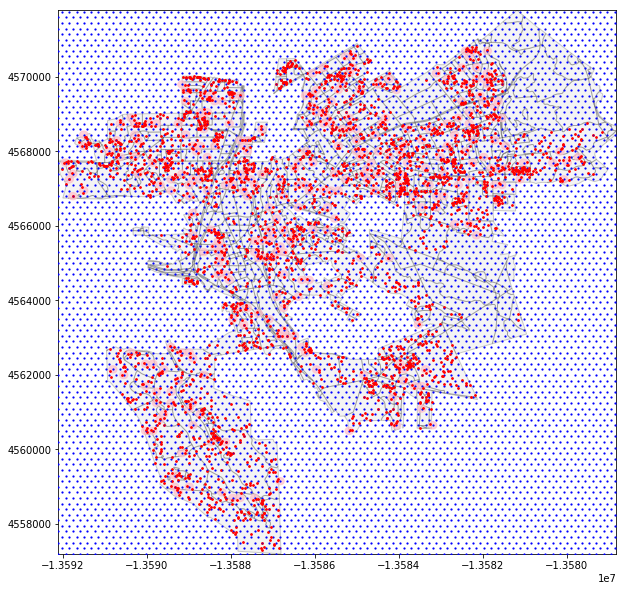

In [80]:
# plot the cut-up city
fig4, ax4 = plt.subplots(figsize=(10,10))
for polygon in tbg_pop_geoms_WC_c2010:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=0)
    ax4.add_patch(patch)
tempx,tempy = zip(*tmp_facilitypts)

ax4.scatter(x=tempx,y=tempy, s=5, c='b', linewidth=0, zorder=3)

#ax3.plot([facility_matches_coords[0][0]],[facility_matches_coords[0][1]],marker='o', markersize=4, color="black")
db.plot_radii(ax4, tmp_coords, 100.0, alpha=0.7, color="pink")

#db.plot_radii(ax4, not_chosen, 100.0, alpha=0.07, color="blue")

for i in range(0, len(rnd_demand_pts_WC)):
    bgpts = rnd_demand_pts_WC[i]
    if len(bgpts) > 0:
        ax4.scatter(x=bgpts['x'], y=bgpts['y'], s=3, c='r', zorder=4)

ax4.scatter(x=trianggridgdf['x'], y=trianggridgdf['y'], s=1, c='b', linewidth=0, zorder=5)


ax4.set_xlim(west, east)
ax4.set_ylim(south, north)
ax4.axis('on')
#plt.savefig("large_soln-p300.png",  dpi=192 * 10)
plt.show()

# Lets do a curve where p=1....2000

In [ ]:
inc_p_solns = []
output  = []

#index: Index for new objective. If you use an index of 0, this routine will change the primary optimization objective.
#priority: Priority for the alternative objective.
#weight: Weight for the alternative objective.
#abstol: Absolute tolerance for the alternative objective. 
#reltol: Relative tolerance for the alternative objective. 
#name: Name of the alternative objective. 

index = [0,1]
priority = [0,0]
weight = [1.,1.]
abstol = [0.,0.]
reltol = [0.,0.]


for i in range(1,2000):
    tmpout = []
    P = i
    # X : POTL FACILITY SITES
    x = m.addVars(range(numPotlFacilitySites), vtype=GRB.BINARY, name="x")
    e = m.addVars(range(numPotlFacilitySites), vtype=GRB.BINARY, name="e")
    y = m.addVars(range(numDemandSites), vtype=GRB.CONTINUOUS, name="y")

    # Add Constraints

    #TODO - not sure what this does/where it should go
    m.update()

    for i in range(numDemandSites):
        #c1
        m.addConstr(quicksum(x[j] + y[i] for j in N[i]) >= 1)
        #c3
        m.addConstr(quicksum(x[j] + e[j] for j in N[i]) >= 1)
    
    #c2
    #m.addConstr(quicksum(x[j] for j in range(numPotlFacilitySites) == P))
    m.addConstr(x.sum() == P)

    #c6
    for i in range(numDemandSites):
        m.addConstr(y[i] >= 0)

    # Set global sense for ALL objectives
    m.ModelSense = GRB.MINIMIZE

    # Set Objectives
        #expr: New alternative objective.

    
    #o1- min amt of demand that is NOT covered
    m.setObjectiveN(quicksum(y[i]*demandWt[i] for i in range(numDemandSites)),
                    index[0], priority[0], weight[0], reltol=reltol[0])#, abstol[0], reltol[0])

    #o2 - (while) min'g w/e you need to add to cover everything
    m.setObjectiveN(quicksum(e[j] for j in range(numPotlFacilitySites)),
                        index[1], priority[1], weight[1], reltol=reltol[1])#, abstol[1], reltol[1])

    #%tb
    siteschosen = []
    try:
        m.optimize()
        m.setParam(GRB.Param.OutputFlag, 0)

        # Status checking
        status = m.Status
        if status == GRB.Status.INF_OR_UNBD:
            tmpout.append("Inf or unbd")
        elif status == GRB.Status.INFEASIBLE:
            tmpout.append("infeasible")
        elif status == GRB.Status.UNBOUNDED:
            tmpout.append("unbounded")
        elif status == GRB.Status.OPTIMAL:
            tmpout.append("optimal")
        else:
            tmpout.append(str(status))

        if status == GRB.Status.INF_OR_UNBD or \
            status == GRB.Status.INFEASIBLE  or \
            status == GRB.Status.UNBOUNDED:
            tmpout.append('The model cannot be solved because it is infeasible or unbounded')
            continue

        if status != GRB.Status.OPTIMAL:
            tmpout.append('Optimization was stopped with status ' + str(status))
            continue

        # Print best selected set
        tmpout.append('Selected elements in best solution:')
        
        for j in range(numPotlFacilitySites):
            if x[j].X > 0.9:
                siteschosen.append(j)
                #tmpstr+=' '
                #print(' x%d' % j, end='')


        # Print number of solutions stored
        nSolutions = m.SolCount
        tmpout.append('Number of solutions found: ' + str(nSolutions))

        # Print objective values of solutions
        if nSolutions > 10:
            nSolutions = 10
        tmpout.append('Objective values for first ' + str(nSolutions) + ' solutions:')
        objvals = []
        for i in range(2): #num of objectives
            m.setParam(GRB.Param.ObjNumber, i)
            #('\tObj%d' % i, end='')
            for e in range(nSolutions):
                m.setParam(GRB.Param.SolutionNumber, e)
                #print(' %6g' % m.ObjNVal, end='')
                objvals.append(m.ObjNVal)
                

    except GurobiError as e:
        tmpout.append('Error code ' + str(e.errno) + ": " + str(e))

    except AttributeError as e:
        tmpout.append('Encountered an attribute error: ' + str(e))
        
    
    tmp_sol = {"index":index, "priority":priority, "weight":weight,
               "abstol":abstol, "reltol":reltol, "soln":siteschosen, 
               "obj1":objvals[0:nSolutions-1], "obj2":objvals[nSolutions:len(objvals)-1]}
    inc_p_solns.append(tmp_sol)
    output.append(tmpout)


In [132]:
def actual_coverage(chosen_sites, N, wts):
    #map coverage to a dict for easy accessing 
    #chosen_sites = siteschosen
    #wts = tmp_wts
    #{facility_site_index}: [list of demand pts covered (index)]
    tmpdict = {}
    for i in range(0,len(N)):
        tmp = N[i]
        for j in range(0,len(tmp)):
            if tmp[j] not in tmpdict.keys():
                tmpdict[tmp[j]] = [i]
            else:
                tmpdict[tmp[j]].append(i)


    covered_pts = []
    for i in range(0,len(chosen_sites)):
        tmp_cov = tmpdict[chosen_sites[i]]

        for j in range(0,len(tmp_cov)):
            if tmp_cov[j] not in covered_pts:
                covered_pts.append(tmp_cov[j])

    cov_pop = 0
    cov_wts = []
    for i in range(0,len(covered_pts)):
        curwt = wts[covered_pts[i]]
        cov_pop += curwt
        cov_wts.append(curwt)

    return covered_pts, cov_pop


In [133]:
cov_pts, cov_pop = actual_coverage(siteschosen, N, tmp_wts)

In [134]:
cov_pop

46782

In [121]:
sum(cov_wts)

46782

In [117]:
len(covered_pts)

729

In [107]:
len(demandSites)

2859

In [119]:
sum(tmp_wts)

64173

In [189]:
def mclp(tmp_demandpts, tmp_wts, tmp_facilitypts, N, P):
    
    #Problem Data

    #FILL IN LATER
    demandSites = tmp_demandpts#[[1,2],[3,4],[4.5,5.3],[6.4,1.0],[4.5,3.3],[6.6,4.9],[8.4,4.3]]
    demandWt = tmp_wts #[20,30,2,5,19,3,14,12,8,12,27]
    potlFacilitySites = tmp_facilitypts #[[5,6],[10,4],[0,1],[3.5,3],[4.5,1],[6.3,9],[5.5,2.5],[9.3,10.3],[2.1,1.5],
                        #[1.7,3.3],[1.7,1.4]]

    # potl covering distance for each site is the same for
    # us in this simple initial try
    S = 100.0


    numDemandSites = len(demandSites)
    numPotlFacilitySites = len(potlFacilitySites)

    m = Model('MCLP-v0.0')


        # X : POTL FACILITY SITES
    x = m.addVars(range(numPotlFacilitySites), vtype=GRB.BINARY, name="x")
    y = m.addVars(range(numDemandSites), vtype=GRB.BINARY, name="y")

    #TODO - not sure what this does/where it should go
    m.update()

    for i in range(numDemandSites):
        #c1
        m.addConstr(quicksum(x[j] + y[i] for j in N[i]) >= 1)


    #c2
    #m.addConstr(quicksum(x[j] for j in range(numPotlFacilitySites) == P))
    m.addConstr(x.sum() == P)


        #Set global sense for ALL objectives
    m.ModelSense = GRB.MINIMIZE

    # Set Objectives
        #expr: New alternative objective.
        #index: Index for new objective. If you use an index of 0, this routine will change the primary optimization objective.
        #priority: Priority for the alternative objective.
        #weight: Weight for the alternative objective.
        #abstol: Absolute tolerance for the alternative objective. 
        #reltol: Relative tolerance for the alternative objective. 
        #name: Name of the alternative objective. 

    index = [0,1]
    priority = [0,0]
    weight = [1.,1.]
    abstol = [0.,0.]
    reltol = [0.,0.]

    #o1- min amt of demand that is NOT covered
    m.setObjective(quicksum(y[i]*demandWt[i] for i in range(numDemandSites)))#, abstol[0], reltol[0])


    #%tb
    siteschosen_mclp = []
    try:
        m.optimize()
        m.setParam(GRB.Param.OutputFlag, 0)

        # Status checking
        status = m.Status
        if status == GRB.Status.INF_OR_UNBD:
            print("Inf or unbd")
        elif status == GRB.Status.INFEASIBLE:
            print("infeasible")
        elif status == GRB.Status.UNBOUNDED:
            print("unbounded")
        elif status == GRB.Status.OPTIMAL:
            print("optimal")
        else:
            print(str(status))

        if status == GRB.Status.INF_OR_UNBD or \
            status == GRB.Status.INFEASIBLE  or \
            status == GRB.Status.UNBOUNDED:
            print('The model cannot be solved because it is infeasible or unbounded')
            sys.exit(1)

        if status != GRB.Status.OPTIMAL:
            print('Optimization was stopped with status ' + str(status))
            sys.exit(1)

        # Print best selected set
        print('Selected elements in best solution:')
        for j in range(numPotlFacilitySites):
            if x[j].X > 0.9:
                siteschosen_mclp.append(j)
                print('')
                print(' x%d' % j, end='')


        # Print number of solutions stored
        nSolutions = m.SolCount
        print('Number of solutions found: ' + str(nSolutions))

        # Print objective values of solutions
        if nSolutions > 10:
            nSolutions = 10
        print('Objective values for first ' + str(nSolutions) + ' solutions:')
        for i in range(1): #num of objectives
            m.setParam(GRB.Param.ObjNumber, i)
            print('\tObj%d' % i, end='')
            for e in range(nSolutions):
                m.setParam(GRB.Param.SolutionNumber, e)
                print(' %6g' % m.ObjNVal, end='')
            print('')

    except GurobiError as e:
        print('Error code ' + str(e.errno) + ": " + str(e))

    except AttributeError as e:
        print('Encountered an attribute error: ' + str(e))

    return siteschosen_mclp



In [190]:
mclp_sites1 = mclp(tmp_demandpts, tmp_wts, tmp_facilitypts, N, 150)

Optimize a model with 2860 rows, 18088 columns and 21569 nonzeros
Variable types: 0 continuous, 18088 integer (18088 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 9e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 64173.000000
Presolve removed 2327 rows and 16676 columns
Presolve time: 0.05s
Presolved: 533 rows, 1412 columns, 2399 nonzeros
Found heuristic solution: objective 34843.000000
Variable types: 0 continuous, 1412 integer (1301 binary)

Root relaxation: objective 2.936000e+04, 508 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    29360.000000 29360.0000  0.00%     -    0s

Explored 0 nodes (508 simplex iterations) in 0.12 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 29360 34843 36186 

Op

In [191]:
len(mclp_sites1)

150

In [192]:
len(siteschosen)

300

In [193]:
cov_pts_mclp1, cov_pop_mclp1 = actual_coverage(mclp_sites1, N, tmp_wts)

In [194]:
cov_pop_mclp1

34813

In [138]:
cov_pop

46782

In [223]:
len(cov_pts)

729

In [1]:
len(tmp_demandpts)

NameError: name 'tmp_demandpts' is not defined

## eliminate the covered pts in step 1

In [195]:
not_mclp2_demandpts = []
not_mclp2_wts = []

for curpt in cov_pts_mclp1:
    not_mclp2_demandpts.append(tmp_demandpts[curpt])
    
    
mclp2_demandpts = list(set(tmp_demandpts)-set(not_mclp2_demandpts))


In [214]:
mclp2_wts = []
for i in range(0,len(tmp_wts)):
    if i not in cov_pts_mclp1:
        mclp2_wts.append(tmp_wts[i])
        
    
    

In [197]:
len(mclp2_demandpts)

2501

In [198]:
len(tmp_demandpts) - len(cov_pts_mclp1)

2501

In [199]:
len(cov_pts_mclp1)

358

In [200]:
len(tmp_demandpts)

2859

In [222]:
cov_pop_mclp1

34813

In [202]:
len(mclp2_wts)

2501

# now we'll do stage 2 of mclp

In [217]:
#Problem Data

#FILL IN LATER
demandSites = mclp2_demandpts#[[1,2],[3,4],[4.5,5.3],[6.4,1.0],[4.5,3.3],[6.6,4.9],[8.4,4.3]]
demandWt = mclp2_wts #[20,30,2,5,19,3,14,12,8,12,27]
potlFacilitySites = tmp_facilitypts #[[5,6],[10,4],[0,1],[3.5,3],[4.5,1],[6.3,9],[5.5,2.5],[9.3,10.3],[2.1,1.5],
                    #[1.7,3.3],[1.7,1.4]]

# potl covering distance for each site is the same for
# us in this simple initial try
S = 100.0


numDemandSites = len(demandSites)
numPotlFacilitySites = len(potlFacilitySites)

m = Model('C-MCLP-v0.0')

# N[i] is the covering set of i (all j that can cover i)
mclp2_N = {}
for i in range(numDemandSites):
    mclp2_N[i] = []
    for j in range(numPotlFacilitySites):
        if distance(demandSites[i], potlFacilitySites[j]) <= S:
            mclp2_N[i].append(j)

#N[98]=[]


In [218]:
mclp_sites2 = mclp(mclp2_demandpts, mclp2_wts, tmp_facilitypts, mclp2_N, 150)

Optimize a model with 2502 rows, 17730 columns and 20754 nonzeros
Variable types: 0 continuous, 17730 integer (17730 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 29360.000000
Presolve removed 2051 rows and 16548 columns
Presolve time: 0.05s
Presolved: 451 rows, 1182 columns, 2008 nonzeros
Found heuristic solution: objective 15699.000000
Variable types: 0 continuous, 1182 integer (1067 binary)

Root relaxation: objective 1.478800e+04, 382 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    14788.000000 14788.0000  0.00%     -    0s

Explored 0 nodes (382 simplex iterations) in 0.10 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 14788 15699 17003 

Op

In [219]:
cov_pts_mclp2, cov_pop_mclp2 = actual_coverage(mclp_sites2, mclp2_N, mclp2_wts)

In [220]:
cov_pop_mclp2

14572

In [230]:
len(cov_pts_mclp2)+len(cov_pts_mclp1)

959

In [225]:
cov_pop_mclp1+cov_pop_mclp2

49385

In [227]:
len(mclp2_demandpts)+len(cov_pts_mclp1)

2859